# Week 1 - Environmental Monitoring & Pollution Control (Corrected & Robust)

This notebook loads a public air-quality dataset (with multiple fallbacks), performs safe preprocessing, and produces basic visualizations required for Week 1 milestone: data loading, cleaning, and visualization.

How to use (Google Colab):
1. Open Colab: https://colab.research.google.com
2. Upload this notebook: File → Upload notebook
3. Run cells from top to bottom (Shift+Enter). If public links fail, the notebook will prompt you to upload a CSV.


In [1]:
# Imports & environment info
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import sys, traceback
sns.set(style='whitegrid')
print('Python version:', sys.version.splitlines()[0])
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Pandas version: 2.2.2
Seaborn version: 0.13.2


In [2]:
# Attempt to load dataset from public URLs.
urls = [
    "https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_air_quality.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.csv"
]

df = None
errors = []

for u in urls:
    try:
        print('\nTrying URL:', u)
        if 'AirQualityUCI' in u:
            temp = pd.read_csv(u, sep=';', decimal=',', engine='python', na_values=[-200])
            temp = temp.dropna(axis=1, how='all')
            df = temp
        else:
            temp = pd.read_csv(u)
            df = temp
        print('Loaded dataset from:', u, 'with shape', df.shape)
        break
    except Exception as e:
        tb = traceback.format_exc().splitlines()[-1]
        errors.append((u, str(e), tb))
        print('Failed to load from', u, ':', e)

if df is None:
    print('\nAll public URL attempts failed. Run the next cell to upload a CSV file from your machine.')
else:
    print('\nPreview of loaded data:')
    display(df.head())


Trying URL: https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_air_quality.csv
Failed to load from https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_air_quality.csv : HTTP Error 404: Not Found

Trying URL: https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.csv
Failed to load from https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.csv : HTTP Error 404: Not Found

All public URL attempts failed. Run the next cell to upload a CSV file from your machine.


In [3]:
# Upload fallback (works in Colab)
if 'df' not in globals() or df is None:
    try:
        from google.colab import files
        print('Please upload a CSV file (use the file picker) - the notebook will try common read patterns.')
        uploaded = files.upload()
        if uploaded:
            name = list(uploaded.keys())[0]
            print('Uploaded file:', name)
            try:
                df = pd.read_csv(name)
                print('Read CSV with default parameters. Shape:', df.shape)
            except Exception as e:
                print('Default read_csv failed:', e)
                try:
                    df = pd.read_csv(name, sep=';', decimal=',', engine='python')
                    print('Read CSV with sep=";" and decimal=",". Shape:', df.shape)
                except Exception as e2:
                    print('Fallback read_csv also failed:', e2)
    except Exception as exc:
        print('Upload widget not available in this environment:', exc)
else:
    print('Dataframe already loaded from a public URL.')

Please upload a CSV file (use the file picker) - the notebook will try common read patterns.


Saving air_quality_sample.csv to air_quality_sample.csv
Uploaded file: air_quality_sample.csv
Read CSV with default parameters. Shape: (200, 8)


In [4]:
# Diagnostic: show basic info if dataframe exists
if 'df' not in globals() or df is None:
    print('No dataframe loaded yet. Please run the previous cells or upload a file.')
else:
    print('Dataframe shape:', df.shape)
    display(df.head(5))
    print('\nColumns:')
    for i,c in enumerate(df.columns):
        print(i+1, '-', c)
    print('\nMissing value counts (top 10):')
    print(df.isna().sum().sort_values(ascending=False).head(10))

Dataframe shape: (200, 8)


,Date,CO,NO2,Ozone,PM2.5,PM10,Temperature,Humidity
0,2024-01-01,1.00,54.9,30.3,37.8,150.2,15.6,73.1
1,2024-01-02,2.38,15.9,110.3,52.6,55.9,26.3,21.7
2,2024-01-03,1.86,21.3,70.5,38.9,128.0,36.2,21.5
3,2024-01-04,1.54,72.9,102.6,27.0,133.1,32.0,42.7
4,2024-01-05,0.47,52.5,52.0,31.3,102.1,34.2,54.2



Columns:
1 - Date
2 - CO
3 - NO2
4 - Ozone
5 - PM2.5
6 - PM10
7 - Temperature
8 - Humidity

Missing value counts (top 10):
Date           0
CO             0
NO2            0
Ozone          0
PM2.5          0
PM10           0
Temperature    0
Humidity       0
dtype: int64


In [5]:
# Automatic pollutant column detection
keyword_map = {
    'CO': ['co', 'carbon monoxide', 'co mean', 'co(g)', 'co(gt)'],
    'NO2': ['no2', 'no2 mean', 'nox', 'nox(gt)'],
    'Ozone': ['ozone', 'o3', 'o3 mean', 'ozone mean'],
    'PM2.5': ['pm2.5', 'pm25', 'pm 2.5', 'pm2_5'],
    'PM10': ['pm10', 'pm 10'],
    'SO2': ['so2', 'so2 mean'],
    'Temperature': ['temp', 'temperature'],
    'Humidity': ['humidity', 'rh', 'relative humidity'],
    'AQI': ['aqi', 'air quality index']
}

def find_columns(df):
    found = {k: [] for k in keyword_map}
    lower_cols = [c.lower() for c in df.columns]
    for k, kws in keyword_map.items():
        for i, lc in enumerate(lower_cols):
            for kw in kws:
                if kw in lc:
                    found[k].append(df.columns[i])
    return found

if 'df' in globals() and df is not None:
    detected = find_columns(df)
    print('Detected columns:')
    for k, v in detected.items():
        print(k+':', v)
    detected_cols = [c for vals in detected.values() for c in vals]
    detected_cols = list(dict.fromkeys(detected_cols))
else:
    detected = {}
    detected_cols = []

Detected columns:
CO: ['CO']
NO2: ['NO2']
Ozone: ['Ozone']
PM2.5: ['PM2.5']
PM10: ['PM10']
SO2: []
Temperature: ['Temperature', 'Temperature']
Humidity: ['Humidity']
AQI: []


In [6]:
# Preprocessing: convert selected columns to numeric and fill missing values with mean
import math
if 'df' not in globals() or df is None:
    print('No dataframe to preprocess.')
else:
    if not detected_cols:
        print('No pollutant columns detected automatically.')
        print('To override, set COLUMN_OVERRIDE = ["col1","col2"] and re-run this cell.')
    else:
        COLUMN_OVERRIDE = None  # e.g., ['NO2 Mean','CO Mean']
        if COLUMN_OVERRIDE:
            use_cols = COLUMN_OVERRIDE
        else:
            use_cols = detected_cols[:6]
        print('Columns selected for preprocessing:', use_cols)
        df_clean = df.copy()
        for c in use_cols:
            df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')
        print('\nNaN counts before filling:')
        print(df_clean[use_cols].isna().sum())
        for c in use_cols:
            try:
                mean_val = df_clean[c].mean()
                if not math.isnan(mean_val):
                    df_clean[c].fillna(mean_val, inplace=True)
            except Exception as e:
                print('Could not fill column', c, ':', e)
        print('\nNaN counts after filling:')
        print(df_clean[use_cols].isna().sum())
        print('\nPreview of cleaned columns:')
        display(df_clean[use_cols].head())

Columns selected for preprocessing: ['CO', 'NO2', 'Ozone', 'PM2.5', 'PM10', 'Temperature']

NaN counts before filling:
CO             0
NO2            0
Ozone          0
PM2.5          0
PM10           0
Temperature    0
dtype: int64

NaN counts after filling:
CO             0
NO2            0
Ozone          0
PM2.5          0
PM10           0
Temperature    0
dtype: int64

Preview of cleaned columns:


/tmp/ipython-input-2083999162.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[c].fillna(mean_val, inplace=True)


,CO,NO2,Ozone,PM2.5,PM10,Temperature
0,1.00,54.9,30.3,37.8,150.2,15.6
1,2.38,15.9,110.3,52.6,55.9,26.3
2,1.86,21.3,70.5,38.9,128.0,36.2
3,1.54,72.9,102.6,27.0,133.1,32.0
4,0.47,52.5,52.0,31.3,102.1,34.2


Visualization columns: ['CO', 'NO2', 'Ozone', 'PM2.5', 'PM10', 'Temperature', 'Humidity']


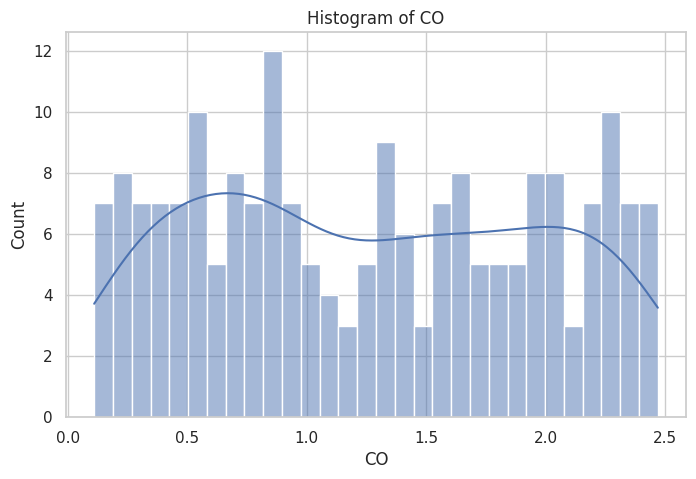

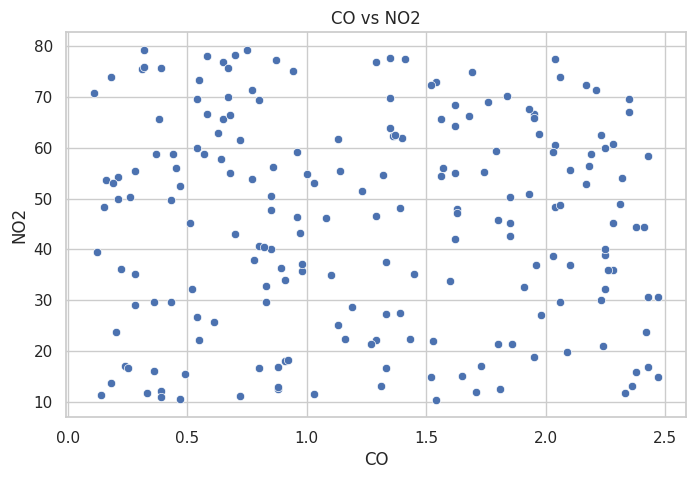

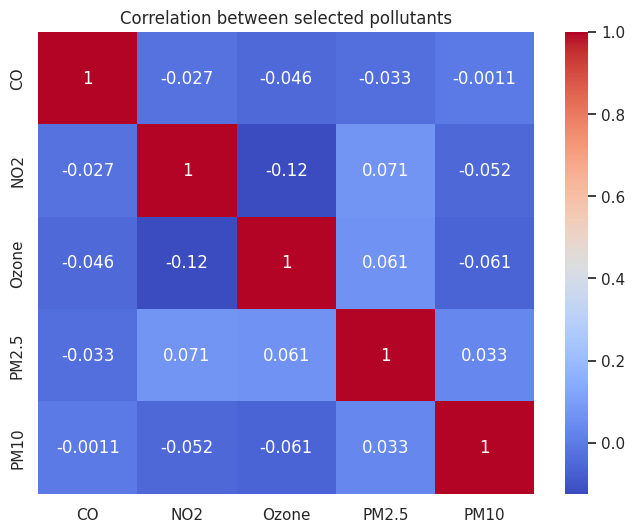

In [7]:
# Visualizations - run only if df_clean exists
if 'df_clean' not in globals():
    print('No cleaned dataframe available. Run preprocessing first.')
else:
    try:
        vis_order = []
        for key in ['CO','NO2','Ozone','PM2.5','PM10','AQI','Temperature','Humidity']:
            if key in detected and detected[key]:
                vis_order.extend(detected[key])
        if not vis_order:
            vis_order = detected_cols[:3]
        vis_order = list(dict.fromkeys(vis_order))
        print('Visualization columns:', vis_order)
        if not vis_order:
            print('No columns selected for visualization.')
        else:
            c0 = vis_order[0]
            plt.figure(figsize=(8,5))
            sns.histplot(df_clean[c0].dropna(), bins=30, kde=True)
            plt.title(f'Histogram of {c0}')
            plt.xlabel(c0)
            plt.show()
            if len(vis_order) >= 2:
                c1 = vis_order[1]
                plt.figure(figsize=(8,5))
                sns.scatterplot(x=df_clean[c0], y=df_clean[c1])
                plt.title(f'{c0} vs {c1}')
                plt.xlabel(c0)
                plt.ylabel(c1)
                plt.show()
            corr_cols = vis_order[:5]
            if len(corr_cols) >= 2:
                plt.figure(figsize=(8,6))
                sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
                plt.title('Correlation between selected pollutants')
                plt.show()
    except Exception as e:
        print('Error during visualization:')
        traceback.print_exc()

In [8]:
# Save cleaned numeric columns to CSV (if available)
if 'df_clean' in globals():
    try:
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            out_path = '/mnt/data/Week1_cleaned_data.csv'
            df_clean[numeric_cols].to_csv(out_path, index=False)
            print('Saved cleaned numeric data to:', out_path)
        else:
            print('No numeric columns found to save.')
    except Exception as e:
        print('Failed to save cleaned CSV:', e)
else:
    print('No cleaned data to save.')

Failed to save cleaned CSV: Cannot save file into a non-existent directory: '/mnt/data'


## Next steps & Submission tips

- Save the notebook in Colab: File → Save a copy in Drive, then File → Download .ipynb and rename it `Week1.ipynb`.
- Upload `Week1.ipynb` to your GitHub repository named `Week1` and commit.
- In LMS Week 1 submission, paste your GitHub repo link and add comments like: "Performed dataset loading, preprocessing, and basic visualizations on public air quality data."

**If you still see an error:** copy the full red error message from Colab and paste it in the chat along with the cell number. I'll debug that exact trace.